# Estaming mantle potential temperature $T_p$

This scripts use the final thermal state of a given scenario to:

<ol>
    <li> Calculate the a profile of horizontal mean
    <li> Fit a line to the asthenospheric region
    <li> Project the fitted line to the surface to obtain the Tp
</ol>

In [1]:
import os
import gc
import sys
import shutil
import subprocess
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib import rc
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

# sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
# from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

# Initial Setup

In [2]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory

#DYNAMIC EQUILIBRIUM SCENARIO
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst'
scenario = 'Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12'
# scenario = 'Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT250oC_Hlit120km_Hast7e-12'
# scenario = 'Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT300oC_Hlit120km_Hast7e-12'
# scenario = 'Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT350oC_Hlit120km_Hast7e-12'
# scenario = 'Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT350oC_Hlit120km_Hast10e-12'

#KEEL SCENARIOS
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT200_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT290_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT350_HprodAst_Lx3000km'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT200_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT290_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT290_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT350_HprodAst_Lx4000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT290_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw'

#Thermal boundary condition fixed
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf_sc'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT500_rheol19_c1250_C1_HprodAst_Hlit80km'


# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo1'
    if(path[1] == 'home'):
        model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}/{scenario}"
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
print(f'Model Path: {model_path}')

model_name = os.path.split(model_path)[1]
print(f'Model name: {model_name}')

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(f'Output Path: {output_path}')

if not os.path.isdir(output_path):
    os.makedirs(output_path)

Model Path: /media/joao_macedo/Joao_Macedo1/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12
Model name: STB_DT230oC_Hlit120km_Hast7e-12
Output Path: /media/joao_macedo/Joao_Macedo1/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/_output


# Read dataset

In [3]:
dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset.info)

<bound method Dataset.info of <xarray.Dataset> Size: 59MB
Dimensions:      (time: 648, x: 161, z: 71)
Coordinates:
  * time         (time) float64 5kB 0.0 1.0 2.0 3.0 ... 644.0 645.0 646.0 647.0
    step         (time) int32 3kB ...
  * x            (x) float64 1kB 0.0 1e+04 2e+04 ... 1.58e+06 1.59e+06 1.6e+06
  * z            (z) float64 568B -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 59MB ...
Attributes: (12/95)
    nx:                                161
    nz:                                71
    lx:                                1600000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:              

In [4]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean
def Tp_estimate(mean_temp, z, zbot, ztop):
    zcond = (z<=zbot+40) & (z>=ztop+40) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b

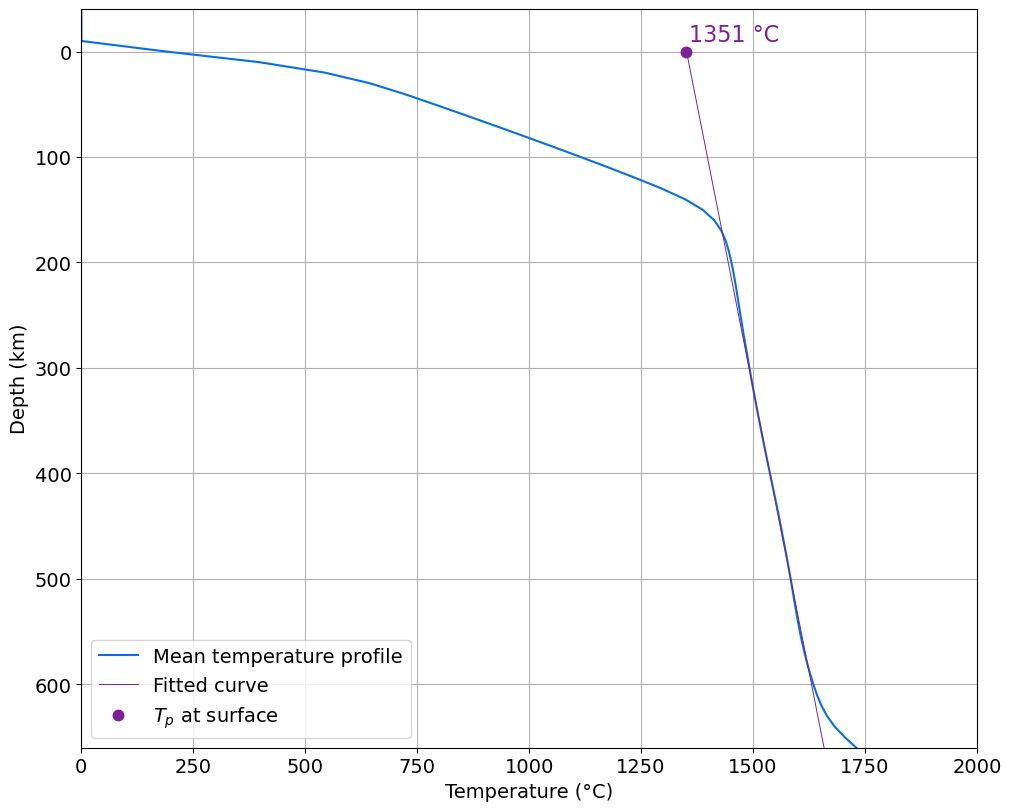

In [5]:
data = dataset.temperature[-1].values.T #Nz vs Nx
T_mean = calc_mean_temperaure_region(data, Nz, xx, 0, Lx/1.0e3)

Tp, Tfit = Tp_estimate(T_mean, z, 580, 150)

#plot temperature profiles
plt.close()
label_fsize = 14
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,8), sharex=True, sharey=True)

ax.plot(T_mean, z-40, linestyle='-', color = 'xkcd:cerulean blue', label = r'Mean temperature profile')

z_aux = z - 40
color_Tp = 'xkcd:purple'
# color_Tp = 'xkcd:scarlet'

ax.plot(Tfit[z_aux>=0], z_aux[z_aux>=0], linestyle='-', linewidth=0.7, color=color_Tp, alpha=1.0, label='Fitted curve')
ax.plot(Tp, 0, '.', markersize=15, color=color_Tp, alpha=1.0, label = r'$T_p$ at surface')

fsize = 16
yshift = 10
xshift = 5
rotation = 0

ax.text(Tp+xshift, 0-yshift, f'{Tp} °C', fontsize=fsize, color=color_Tp, rotation=rotation)
#plot details
ax.set_xlim([0,2000])
ax.set_ylim([660, -40])
ax.set_xlabel('Temperature (°C)', fontsize=label_fsize)
ax.set_ylabel('Depth (km)', fontsize=label_fsize)
ax.grid(':k')
ax.legend(loc='lower left', fontsize=label_fsize)

figname = f"{scenario.split('/')[-1]}_Tp_estimate"

fig.savefig(f'{output_path}/{figname}.png', dpi=300)
fig.savefig(f'{output_path}/{figname}.pdf', dpi=300)